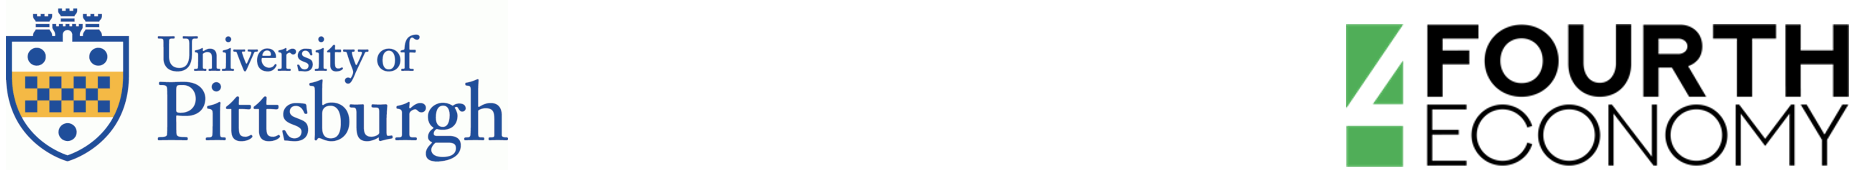

In [1]:
# Display logos
library("IRdisplay")
display_png(file="logos.png")

In [2]:
# Add "Toggle code" button
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click to toggle on/off the raw code.">
 </form>'
)

# US Affordable Housing Shortage

**Natalee Morris, Gayatri Pai, and Mason Putt**

### Project Overview

The Covid-19 global pandemic has brought about a wave of joblessness and housing insecurity for millions of American families. This analysis aims to explore the extent to which this negative unemployment shock causes housing displacement among renters in all US counties, specifically in counties that were already facing housing shortages prior to the pandemic. We use data ranging from 2008-2017 to show how higher unemployment and housing affordability gaps leads to higher rates of evictions, and how this effect is different across counties with different rurality or racial breakdowns.

<font color=red> Add results overview / some background </font>

This is an academic project completed by members of the [University of Pittsburgh's MS in Quantitative Economics program](https://www.mqe.pitt.edu/), advised by Pittsburgh consulting firm [Fourth Economy](https://www.fourtheconomy.com/).

### Data Description

We define housing affordability statistics using data from the **Comprehensive Housing Affordability Strategy**, or CHAS, in the form of 5-year estimates from 2008-12 and 2013-17. The 2013-17 period provides a baseline estimate for the state of a given county's hosuing market prior to the onset of Covid-19, while the 2008-12 period gives some insight into how that county responded to the 2008 recession, which also caused an unemployment shock. 

This dataset is then merged with data from the following sources, also aggregated into 5-year averages:

- **Princeton University's Eviction Lab**: Estimates of evictions and demographic information
- **Economic Research Service** 2015 Database: Binaries to indicate a county's economic typology
- **ACS School Enrollment Survey**: Estimates of college enrollment in a given county

<font color=red> Hyperlink sources? </font>

The following variables are used to define housing markets and local economies:

- *population*: A raw count of the total population
- *unemp_rate*: Unemployed population divided by the total labor force
- *renter_rate*: The proportion of a county's population that rents (rather than owns) housing
- *evict_rate*: Number of evictions divided by number of renters
- *nonwhite_rate*: Proportion of a county's population that is nonwhite
- *r_totalgap_rate*: The proportion of a county's population that does not have affordable rental housing available to them
- *college_rate*: The proportion of a county's population attending college
- *costbur_rate*: The proportion of renters facing cost burden or severe cost burden - spending at least 30% of their income on housing
- *metro*: A binary indicating counties constaining one or more urbanized areas

The full dataset and data dictionary of sources / variable deifnitions can be found at https://github.com/MasonPutt/4E-Capstone-Project. Here, we also provide an identical dataset that forces the data into 1-year estimates rather than 5-year averages. To avoid making false assumptions about the state of housing markets (i.e. assuming identicality in housing markets between 2008 and 2012), our analysis utilizes 5-year averages.

The following gives an example of the data format, for the first three counties in the US alphabetically:

**Table 1: Data Format**

In [4]:
options(warn=-1)
options(message=-1)

library(kableExtra)
library(IRdisplay)
library(tidyverse)

# Load data
alldata5yr <-read.csv("https://raw.githubusercontent.com/MasonPutt/4E-Capstone-Project/main/alldata5yr.csv")
kable(head(alldata5yr[c(3,6,22,7,8,9,10,15,17,18,112)],6), format='html') %>%
    as.character() %>%
    display_html() 

# Define options
Pitt.Blue<- "#003594"
Pitt.Gold<-"#FFB81C"

county_state,period,population,unemp_rate,renter_rate,evict_rate,nonwhite_rate,r_totalgap_rate,college_rate,costbur_rate,metro
"Abbeville County, SC",2008-2012,25221.0,0.1178,0.2232,0.0095,0.3090,0.1542,0.0611,0.4286,0
"Abbeville County, SC",2013-2017,24997.0,0.0688,0.2295,0.0418,0.3108,0.2923,0.0616,0.4288,0
"Acadia Parish, LA",2008-2012,61066.2,0.0610,0.3067,0.0079,0.2168,0.1735,0.0350,0.3390,1
"Acadia Parish, LA",2013-2017,62163.0,0.0636,0.2867,0.0220,0.2230,0.1938,0.0344,0.4192,1
"Accomack County, VA",2008-2012,35287.6,0.0705,0.2951,0.0270,0.3900,0.2214,0.0332,0.2918,0
"Accomack County, VA",2013-2017,33115.0,0.0577,0.3001,0.0230,0.3908,0.2783,0.0354,0.4039,0


The main features of the data are described below for all 3,141 geographies (3,006 counties, 14 boroughs, and 11 census areas) that make up the United States in the 2013-2017 period. The median and mean of each variable give us insight into what the average county looks like, and provides a starting point for considering the normality assumptions in the modeling process.

**Table 2: Summary Statistics**

In [5]:
library(skimr)
options(scipen = 999)

# Extract only 2013-17 data
recent <- filter(alldata5yr, period=='2013-2017')

# Creates summary table
sumtab <- t(t(skim(recent[c(22,7,8,9,10,15,17,18,112)])))
sumtab <- sumtab[, c(2:3, 7:9, 5, 10:12)]
sumtab <- as.data.frame(sumtab) %>%
    select('Variable'=1,'Number Missing'=2,'Min'=3,'1st Quartile'=4,'Median'=5,'Mean'=6,'3rd Quartile'=7,'Max'=8, 'Var Distribution'=9)
sumtab[2:7] <- lapply(sumtab[2:7],as.numeric)
kable(sumtab, format = "html") %>%
    as.character() %>%
    display_html() 
     

Variable,Number Missing,Min,1st Quartile,Median,Mean,3rd Quartile,Max,Histogram
population,1,85.0000,11030.000000,25768.0000,100776.6108280,67492.75000,10038388.0000,▇▁▁▁▁
unemp_rate,1,0.0179,0.044100,0.0559,0.0580238,0.06880,0.2350,▇▅▁▁▁
renter_rate,0,0.0588,0.231500,0.2741,0.2865895,0.32480,0.9091,▃▇▁▁▁
evict_rate,542,0.0000,0.004800,0.0121,0.0172846,0.02430,0.1737,▇▁▁▁▁
nonwhite_rate,1,0.0024,0.066475,0.1536,0.2271571,0.34375,0.9905,▇▃▂▁▁
r_totalgap_rate,0,0.0000,0.107100,0.1631,0.1611107,0.21250,0.4609,▃▇▆▁▁
college_rate,3,0.0000,0.030600,0.0406,0.0509359,0.05800,0.5749,▇▁▁▁▁
costbur_rate,0,0.0000,0.305600,0.3685,0.3593675,0.42380,0.6766,▁▂▇▅▁
metro,0,0.0000,0.000000,0.0000,0.3712194,1.00000,1.0000,▇▁▁▁▅


<font color=red> What is the 1 missing? BEDFORD </font>

**A note on missing data:**



Of the 6,282 observations (3,014 geographies over two periods), we find 1,066 missing observations for eviction rates, 542 (50.8%) of which occured in the 2013-2017 time period. For simplicity in the modeling process, we assume that the distribution of missing observations is essentialy random. The table below describes the main features of the missing observations from the 2013-2017 period:

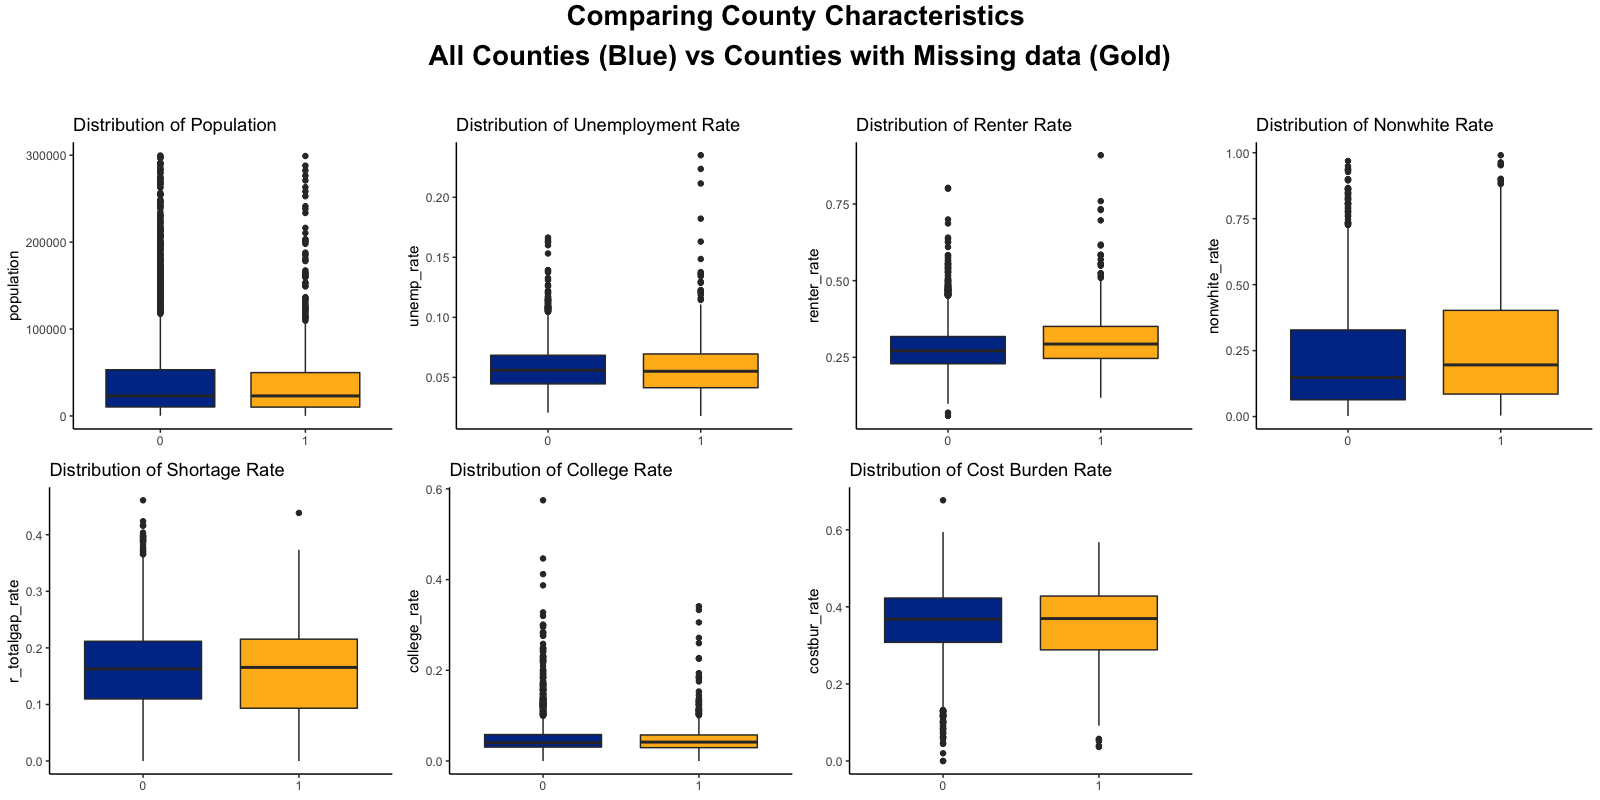

In [6]:
library(ggpubr)

# Creates binary for missing data
recent$missing <- as.integer(complete.cases(recent))
recent$missing <- ifelse(recent$missing==0,1,0)

# Pulls proportion of counties with missing data by state
#aggregate(recent['missing'], list(recent$state), mean)

# Creates boxplots, coloring by missing binary
pop <- ggplot(data=recent, aes(y=population, x=as.factor(missing), fill=as.factor(missing))) + 
        geom_boxplot() + theme_classic() + ggtitle("Distribution of Population")+ theme(legend.position = "none", axis.title.x=element_blank()) +
        ylim(c(0,300000))+ scale_fill_manual(values=c(Pitt.Blue, Pitt.Gold))
un <- ggplot(data=recent, aes(y=unemp_rate, x=as.factor(missing), fill=as.factor(missing))) + 
        geom_boxplot() + theme_classic() + ggtitle("Distribution of Unemployment Rate")+ theme(legend.position = "none", axis.title.x=element_blank())+ 
        scale_fill_manual(values=c(Pitt.Blue, Pitt.Gold))
rr <- ggplot(data=recent, aes(y=renter_rate, x=as.factor(missing), fill=as.factor(missing))) + 
        geom_boxplot() + theme_classic() + ggtitle("Distribution of Renter Rate")+ theme(legend.position = "none", axis.title.x=element_blank())+ 
        scale_fill_manual(values=c(Pitt.Blue, Pitt.Gold))
nw <- ggplot(data=recent, aes(y=nonwhite_rate, x=as.factor(missing), fill=as.factor(missing))) + 
        geom_boxplot() + theme_classic() + ggtitle("Distribution of Nonwhite Rate")+ theme(legend.position = "none", axis.title.x=element_blank())+ 
        scale_fill_manual(values=c(Pitt.Blue, Pitt.Gold))
tgr <- ggplot(data=recent, aes(y=r_totalgap_rate, x=as.factor(missing), fill=as.factor(missing))) + 
        geom_boxplot() + theme_classic() + ggtitle("Distribution of Shortage Rate")+ theme(legend.position = "none", axis.title.x=element_blank())+ 
        scale_fill_manual(values=c(Pitt.Blue, Pitt.Gold))
col <- ggplot(data=recent, aes(y=college_rate, x=as.factor(missing), fill=as.factor(missing))) + 
        geom_boxplot() + theme_classic() + ggtitle("Distribution of College Rate")+ theme(legend.position = "none", axis.title.x=element_blank())+ 
        scale_fill_manual(values=c(Pitt.Blue, Pitt.Gold))
cb <- ggplot(data=recent, aes(y=costbur_rate, x=as.factor(missing), fill=as.factor(missing))) + 
        geom_boxplot() + theme_classic() + ggtitle("Distribution of Cost Burden Rate")+ theme(legend.position = "none", axis.title.x=element_blank()) + 
        scale_fill_manual(values=c(Pitt.Blue, Pitt.Gold))

options(repr.plot.width = 16, repr.plot.height = 8, repr.plot.res = 100)

# Display boxplots in grid form
bplots <- ggarrange(pop,un,rr,nw,tgr,col,cb, ncol=4, nrow=2)
annotate_figure(bplots,
               top = text_grob("Comparing County Characteristics \nAll Counties (Blue) vs Counties with Missing data (Gold)\n", face = "bold", size = 20)
)

We see very similar measures of spread and central tendency for the characteristics between counties with and without missing eviction data. That being said, the there are geographic trends that exist between counties with missing data. The following are a few disclaimers regarding missing observations and the bias they induce:

- The following states have missing data for every county: Alaska, Arkansas, North Dakota, South Dakota
- The following states have missing data for over 50% of counties: Arizona, Maryland, New York
- <font color=red> Why are these results missing? </font>

<font color=red> Probably move this to modeling section: </font>

<font color=red> + add discussion </font>

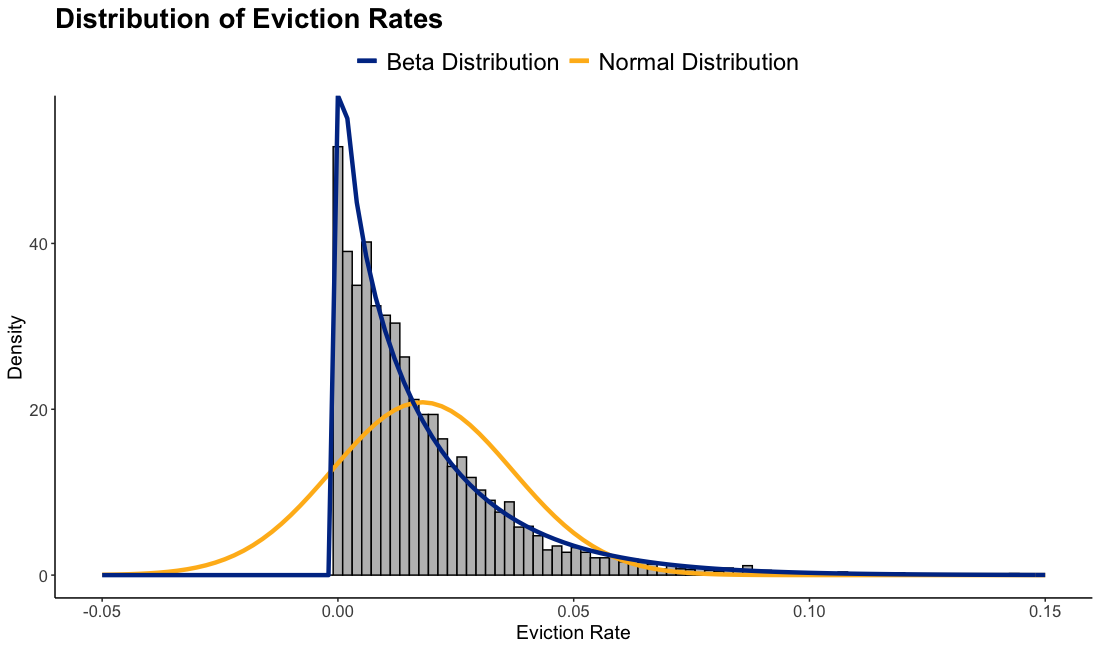

In [8]:
library(EnvStats)
# Pull coefficients to graph beta distribution
betacoefs <- ebeta(na.omit(alldata5yr)$evict_rate, method = "mle")

# Create plot
options(repr.plot.width = 11, repr.plot.height = 6.5)
ggplot(alldata5yr, aes(x=evict_rate)) + 
    geom_histogram(aes(y = ..density..), bins = 100, fill='grey', col='black') + xlim(c(-0.05, 0.15)) +
    stat_function(fun = dnorm, args = list(mean(na.omit(alldata5yr)$evict_rate), sd(na.omit(alldata5yr)$evict_rate)), aes(colour = Pitt.Gold), size=1.5) +
    stat_function(fun = dbeta, args = list(betacoefs$parameters[1], betacoefs$parameters[2]), aes(colour = Pitt.Blue), size=1.5) + ylab("Density")+ xlab("Eviction Rate")+
    theme_classic() + ggtitle("Distribution of Eviction Rates") + theme(axis.text=element_text(size=12), plot.title=element_text(size=20,face="bold"),
        axis.title=element_text(size=14)) + 
    scale_colour_manual("", values = c(Pitt.Blue, Pitt.Gold), labels = c("Beta Distribution", "Normal Distribution")) + 
    theme(legend.text = element_text(size = 17), legend.position="top")


### Modeling

We use two type of models to.... <font color=red> etc., add graph </font>

<font color=red> Mention why we even show normal dist </font>

<font color=red> Mention assumptions </font>

<font color=red> Mention controls </font>

Note: In our beta regression model, we first transform the dependent variable (eviction rates) to make them abide to the standard unit interval (0,1). This is necessary step mathematically, as the beta distribution bounds estimates to the open (0,1) interval. The transformation we use follows the methods of [Smithson and Verkuilen, 2006](https://pubmed.ncbi.nlm.nih.gov/16594767/): 

$$alt\_evictrate = \frac{(evictrate*(n-1)+0.5)}{n}$$

In the context of our data, this would transform an eviction rate of 0 to 0.00008, or an eviction rate of 0.1 would become 0.10006. This is a minor transformation that is not intended to alter our interpretation of the variable, but it allows the beta model to run.

**Table 3: Eviction Rate Regression Modeling**

In [9]:
# First, we create regions to be used as fixed effects in modeling

NE.name <- c("Connecticut","Maine","Massachusetts","New Hampshire",
              "Rhode Island","Vermont","New Jersey","New York",
              "Pennsylvania")
 
MW.name <- c("Indiana","Illinois","Michigan","Ohio","Wisconsin",
              "Iowa","Kansas","Minnesota","Missouri","Nebraska",
              "North Dakota","South Dakota")
 
S.name <- c("Delaware","District of Columbia","Florida","Georgia",
             "Maryland","North Carolina","South Carolina","Virginia",
             "West Virginia","Alabama","Kentucky","Mississippi",
             "Tennessee","Arkansas","Louisiana","Oklahoma","Texas")
 
W.name <- c("Arizona","Colorado","Idaho","New Mexico","Montana",
             "Utah","Nevada","Wyoming","Alaska","California",
             "Hawaii","Oregon","Washington")

region.list <- list(
     Northeast=NE.name,
     Midwest=MW.name,
     South=S.name,
     West=W.name)

alldata5yr$region <- sapply(alldata5yr$state, 
                      function(x) names(region.list)[grep(x,region.list)])
alldata5yr$region <- as.character(alldata5yr$region)

In [11]:
library(lfe)
library(stargazer)
library(xtable)
library(IRdisplay)
library(repr)
library(mfx)
library(betareg)
library(texreg)

alldata5yr$alt_evrate <- (alldata5yr$evict_rate * (6281) + 0.5) / 6282

# Run models
ols <- lm(evict_rate ~ costbur_rate+unemp_rate, data=alldata5yr)
ols_int <- lm(evict_rate ~ costbur_rate+unemp_rate+costbur_rate*unemp_rate, data=alldata5yr)
ols_controls <- lm(evict_rate ~ costbur_rate+unemp_rate+costbur_rate*unemp_rate+metro+nonwhite_rate+college_rate+as.factor(period)+as.factor(region), data=alldata5yr)
betam <- betamfx(alt_evrate ~ costbur_rate+unemp_rate, data=alldata5yr)
betam_int <- betamfx(alt_evrate ~ costbur_rate+unemp_rate+costbur_rate*unemp_rate, data=alldata5yr)
betam_controls <- betamfx(alt_evrate ~ costbur_rate+unemp_rate+costbur_rate*unemp_rate+metro+nonwhite_rate+college_rate+as.factor(period)+as.factor(region), data=alldata5yr)

# Extracts predictions (using same beta model, different formatting to use predict command)
beta_controls <- betareg(alt_evrate ~ costbur_rate+unemp_rate+unemp_rate*costbur_rate+metro+nonwhite_rate+college_rate+as.factor(period)+as.factor(region), data=alldata5yr)
alldata5yr$pred_evrate <- predict(beta_controls, alldata5yr)
alldata5yr$pred_error <- alldata5yr$pred_evrate-alldata5yr$evict_rate

beta_noint <- betareg(alt_evrate ~ costbur_rate+unemp_rate+metro+nonwhite_rate+college_rate+as.factor(period)+as.factor(region), data=alldata5yr)

# Creates results table
a <- screenreg(list(ols, ols_int, ols_controls, betam, betam_int, betam_controls), custom.header = list("OLS: Eviction Rate"=1:3, "Beta Reg: Alt Eviction Rate"=4:6),
             custom.model.names = c("    OLS", "Interaction", " Controls", "    Beta", "Interaction", "Controls"), digits=3,
             custom.coef.map = list("costbur_rate" = "Proportion Cost Burdened", "unemp_rate" = "Unemployment Rate", "costbur_rate:unemp_rate" = "Interaction (Unemp*CostBur)", "metro" = "Metropolitan", "nonwhite_rate" = "Proportion Nonwhite", "college_rate"="Proportion in College", "as.factor(period)2013-2017"="2013-17 Period"),
             groups = list("Main Effects" = 1:3, "Controls" = 4:7), inner.rule = "_", outer.rule = "=",
             include.rsquared = F, include.pseudors = F, custom.gof.rows=list("Region Fixed Effects" = c("No", "No", "Yes", "No", "No", "Yes")), reorder.gof = c(1, 3, 2,4), column.spacing=0)
write.table(a, quote = FALSE, eol='', row.names=FALSE, col.names=FALSE)


                                        OLS: Eviction Rate               Beta Reg: Alt Eviction Rate      
                               ___________________________________________________________________________
                                   OLS     Interaction  Controls       Beta     Interaction  Controls     
__________________________________________________________________________________________________________
Main Effects                                                                                              
                                                                                                          
    Proportion Cost Burdened      0.077 ***   0.059 ***   0.028 ***    0.060 ***    0.071 ***    0.057 ***
                                 (0.003)     (0.007)     (0.007)      (0.002)      (0.005)      (0.005)   
    Unemployment Rate             0.029 **   -0.070      -0.133 ***    0.011        0.075 **     0.053    
                                 (0.

<font color=red> Discuss results, predictions, model choice </font>

<font color=red> Add contour graph? </font>

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



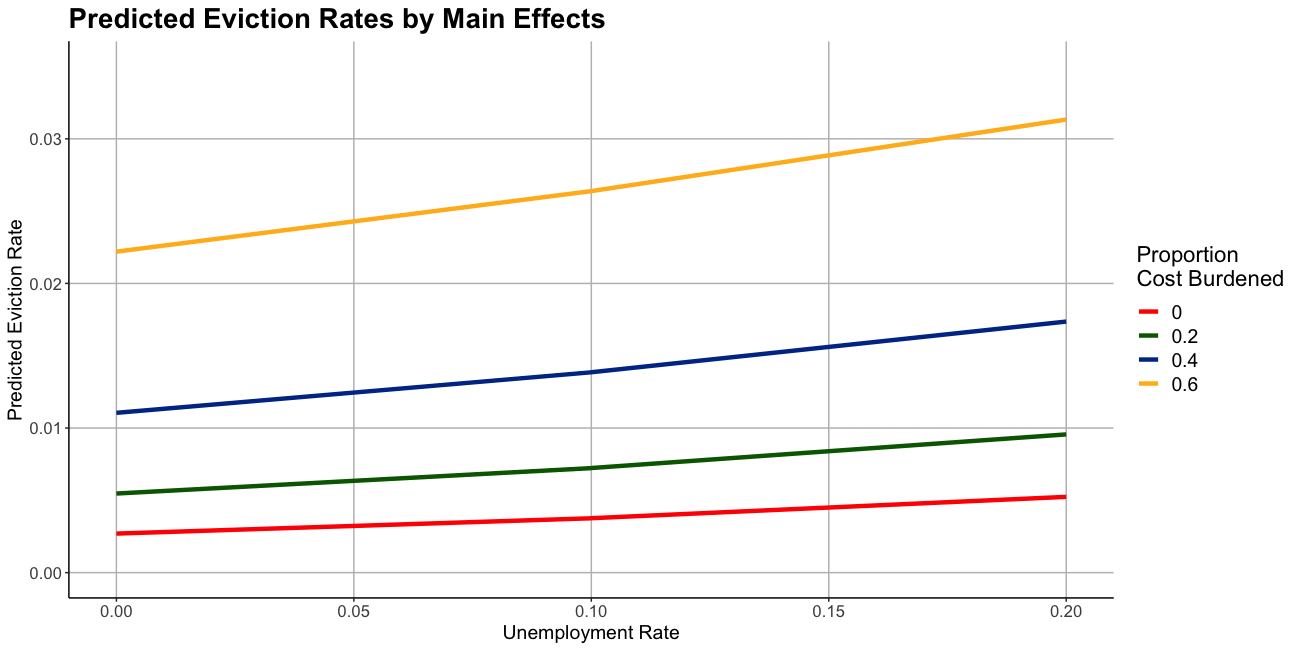

In [15]:
library(sjPlot)
options(repr.plot.width = 13, repr.plot.height = 6.5)
plot_model(beta_controls, type = "pred", terms = c("unemp_rate","costbur_rate[0,0.2,0.4,0.6]"), ci.lvl = NA, line.size=1.5)+ylim(c(0,0.035)) + 
    theme_classic() + ggtitle("Predicted Eviction Rates by Main Effects") + xlab('Unemployment Rate') + ylab('Predicted Eviction Rate') +
    theme(axis.text=element_text(size=12), plot.title=element_text(size=20,face="bold"), axis.title=element_text(size=14), legend.title=element_text(size=16)) + 
    scale_colour_manual("Proportion \nCost Burdened", values = c("red", "darkgreen", Pitt.Blue, Pitt.Gold), labels = c("0", "0.2", "0.4", "0.6")) + 
    theme(legend.text = element_text(size = 14)) + theme(panel.grid.major = element_line(colour = "grey"))

### Data Visualization

<font color=red> Full description of mapped variable, point out important features </font>

https://htmlpreview.github.io/?https://github.com/MasonPutt/4E-Capstone-Project/blob/main/Shortage_map.html

### Suggestions for Further Research

- Aggregation at a city or tract level
- <font color=red> Add to this </font>